In [1]:
import os
import sys
import warnings

sys.path.append("..")

import critical_loads as cl
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd

warnings.simplefilter("ignore")
plt.style.use("ggplot")

# Updating critical loads for water

## Part E: Calculating critical loads

The original water chemistry data used to calculate critical loads and exceedances for water is stored in the Critical Loads database. For the updated workflow, we will use the new TOC and runoff values for the entire period. For exceedance calculations involving NO3, we will use the old BLR data from the database for periods before 1992, and then the updated values for 1992 onwards.

In [2]:
eng = nivapy.da.connect_postgis(database="critical_loads")

Connection successful.


## 1. Read updated BLR summaries

In [3]:
blr_df = pd.read_csv("updated_blr_summary.csv")
blr_df.rename({"cell_id": "Region_id"}, axis="columns", inplace=True)
blr_df.head()

,Region_id,NO3_NO2_ugpl_orig,TOC_mgpl_orig,NO3_NO2_ugpl_1990,NO3_NO2_ugpl_1991,NO3_NO2_ugpl_1992,NO3_NO2_ugpl_1993,NO3_NO2_ugpl_1994,NO3_NO2_ugpl_1995,NO3_NO2_ugpl_1996,...,NO3_NO2_ugpl_2019,NO3_NO2_ugpl_2020,NO3_NO2_ugpl_2021,runoff_mmpyr,Bare_area_km2,Forest_area_km2,Lake_area_km2,Other_area_km2,Peat_area_km2,Total_area_km2
0,58005004,NaN,NaN,393.835612,395.964030,393.674316,388.737834,383.531820,380.200358,379.023071,...,201.035319,197.939290,196.050456,1538.956424,0.0,7.948615,3.531350,41.628183,0.629654,53.737802
1,58006001,365.0,0.4,492.149920,494.809696,491.948397,485.779607,479.274038,475.110897,473.639663,...,251.220353,247.351442,244.991146,1815.066026,0.0,39.423553,31.021262,120.018516,2.302335,192.765666
2,58006002,215.0,0.8,230.416502,231.661757,230.322142,227.434032,224.388205,222.439101,221.750324,...,117.617245,115.805869,114.700819,2048.172561,0.0,76.189291,24.367177,97.210623,5.545539,203.312629
3,58006003,200.0,0.6,196.950470,198.014855,196.869804,194.401170,191.797741,190.131716,189.542969,...,100.534348,98.986059,98.041506,2013.350677,0.0,124.789407,36.497710,38.501417,3.524085,203.312618
4,58006004,300.0,0.8,144.192230,144.971488,144.133176,142.325818,140.419788,139.200061,138.769014,...,73.603631,72.470100,71.778569,1821.082721,0.0,161.622746,12.593858,16.768307,12.327718,203.312629


## 2. Estimate critical loads

In [4]:
# st_yr = 1982
# end_yr = 2017

# # Loop over 5-year periods
# for year in range(st_yr, end_yr + 1, 5):
#     # Get start and end years for period
#     st_per = year
#     end_per = st_per + 4
#     print(f"Processing {st_per} to {end_per}")

#     # Get original data from database
#     req_df, opt_df, mag_df = cl.read_orig_blr_data(eng, dropna=False)

#     # Update with new values
#     req_df = cl.update_required_pars(req_df, blr_df, st_per, end_per)
#     opt_df = cl.estimate_optional_pars(req_df, blr_df)

#     # Calculate CLs for water
#     cl_csv_path = f"../../water_cls/updated_cls_by_blr/updated_cls_by_blr_{st_per}-{str(end_per)[2:]}.csv"
#     cl_df = cl.calculate_critical_loads_for_water(
#         req_df=req_df, opt_df=opt_df, mag_df=mag_df, out_csv=cl_csv_path
#     )

## Compare old versus new

The code below runs the old workflow and the new one for a single 5-year time period and then compares the results for each parameter.

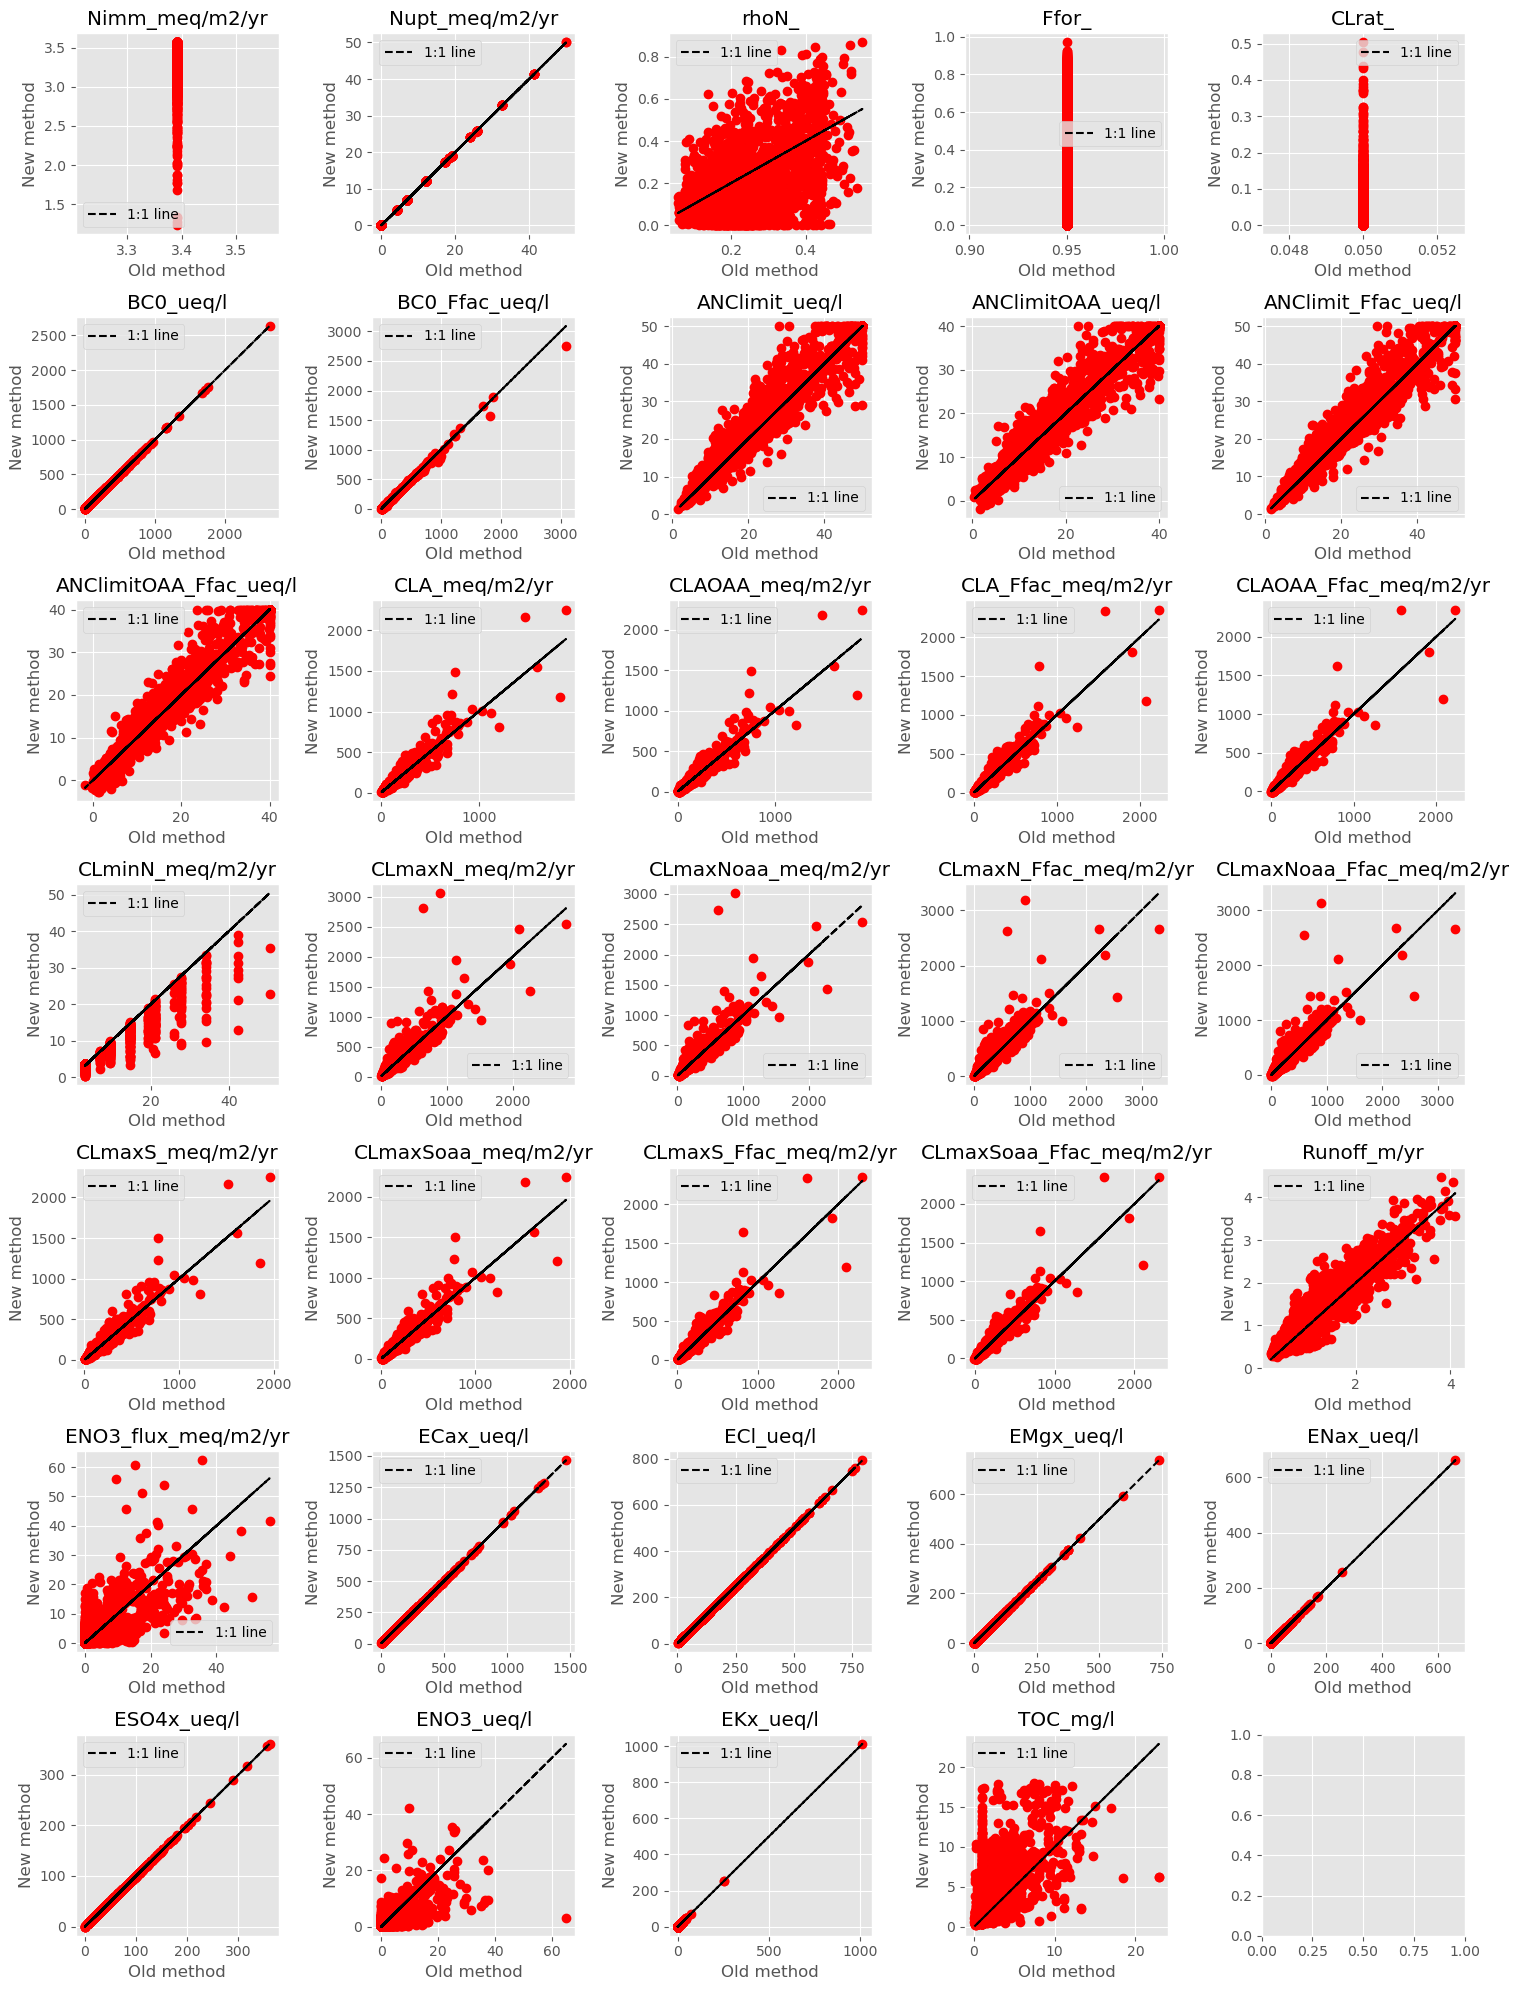

In [5]:
# Compare old versus new for a single time period
st_per, end_per = 1992, 1996

# Original workflow with all defaults as in database
req_df, opt_df, mag_df = cl.read_orig_blr_data(eng, dropna=False)
cl_df_old = cl.calculate_critical_loads_for_water(
    req_df=req_df, opt_df=opt_df, mag_df=mag_df
)

# Updated workflow with new data for runoff, TOC, NO3. Also uses accurate
# land cover proportions per BLR and the modified approach for N immobilisation
# and denitrification
req_df, opt_df, mag_df = cl.read_orig_blr_data(eng, dropna=False)
req_df = cl.update_required_pars(req_df, blr_df, st_per, end_per)
opt_df = cl.estimate_optional_pars(req_df, blr_df)
cl_df = cl.calculate_critical_loads_for_water(
    req_df=req_df, opt_df=opt_df, mag_df=mag_df
)

# Plot
par_cols = [
    col for col in cl_df.columns if ((col != "Region_id") and ("magic" not in col))
]
comp_df = pd.merge(
    cl_df_old, cl_df, on="Region_id", how="inner", suffixes=["_old", "_new"]
)
fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(15, 20))
axes = axes.flatten()
for idx, par in enumerate(par_cols):
    axes[idx].plot(comp_df[f"{par}_old"], comp_df[f"{par}_new"], "ro")
    axes[idx].plot(
        comp_df[f"{par}_old"], comp_df[f"{par}_old"], "k--", label="1:1 line"
    )
    axes[idx].set_xlabel("Old method")
    axes[idx].set_ylabel("New method")
    axes[idx].set_title(par)
    axes[idx].legend()
plt.tight_layout()

In [6]:
# Get BLRs
blr_gdf = nivapy.da.read_postgis("deposition", "dep_grid_blr", eng).to_crs("epsg:25833")
blr_gdf = blr_gdf[["cell_id", "geom"]]
blr_gdf.head()

,cell_id,geom
0,58005004,"MULTIPOLYGON (((-25471.982 6514836.998, -25514..."
1,58006001,"MULTIPOLYGON (((-10886.678 6503779.108, -20006..."
2,58006002,"MULTIPOLYGON (((3660.479 6501900.217, -10886.6..."
3,58006003,"MULTIPOLYGON (((18211.985 6500076.038, 3660.47..."
4,58006004,"MULTIPOLYGON (((32767.708 6498306.548, 18211.9..."


In [7]:
par_list = [
    "CLAOAA_meq/m2/yr_new",
    "CLAOAA_meq/m2/yr_old",
    "CLmaxNoaa_meq/m2/yr_new",
    "CLmaxNoaa_meq/m2/yr_old",
    "CLmaxSoaa_meq/m2/yr_new",
    "CLmaxSoaa_meq/m2/yr_old",
]
comp_df2 = comp_df[["Region_id"] + par_list].copy()
comp_df2.rename({"Region_id": "cell_id"}, axis="columns", inplace=True)
comp_gdf = blr_gdf.merge(comp_df2, on="cell_id", how="left")
comp_gdf.head()

,cell_id,geom,CLAOAA_meq/m2/yr_new,CLAOAA_meq/m2/yr_old,CLmaxNoaa_meq/m2/yr_new,CLmaxNoaa_meq/m2/yr_old,CLmaxSoaa_meq/m2/yr_new,CLmaxSoaa_meq/m2/yr_old
0,58005004,"MULTIPOLYGON (((-25471.982 6514836.998, -25514...",NaN,NaN,NaN,NaN,NaN,NaN
1,58006001,"MULTIPOLYGON (((-10886.678 6503779.108, -20006...",29.534090,28.512144,49.424149,40.486461,30.843365,29.034981
2,58006002,"MULTIPOLYGON (((3660.479 6501900.217, -10886.6...",27.190040,32.029639,42.081570,43.473101,27.985566,32.471017
3,58006003,"MULTIPOLYGON (((18211.985 6500076.038, 3660.47...",6.831604,20.886871,13.252828,29.562611,7.136165,21.183627
4,58006004,"MULTIPOLYGON (((32767.708 6498306.548, 18211.9...",-2.326757,18.913935,19.919026,49.910628,-2.366328,19.188930


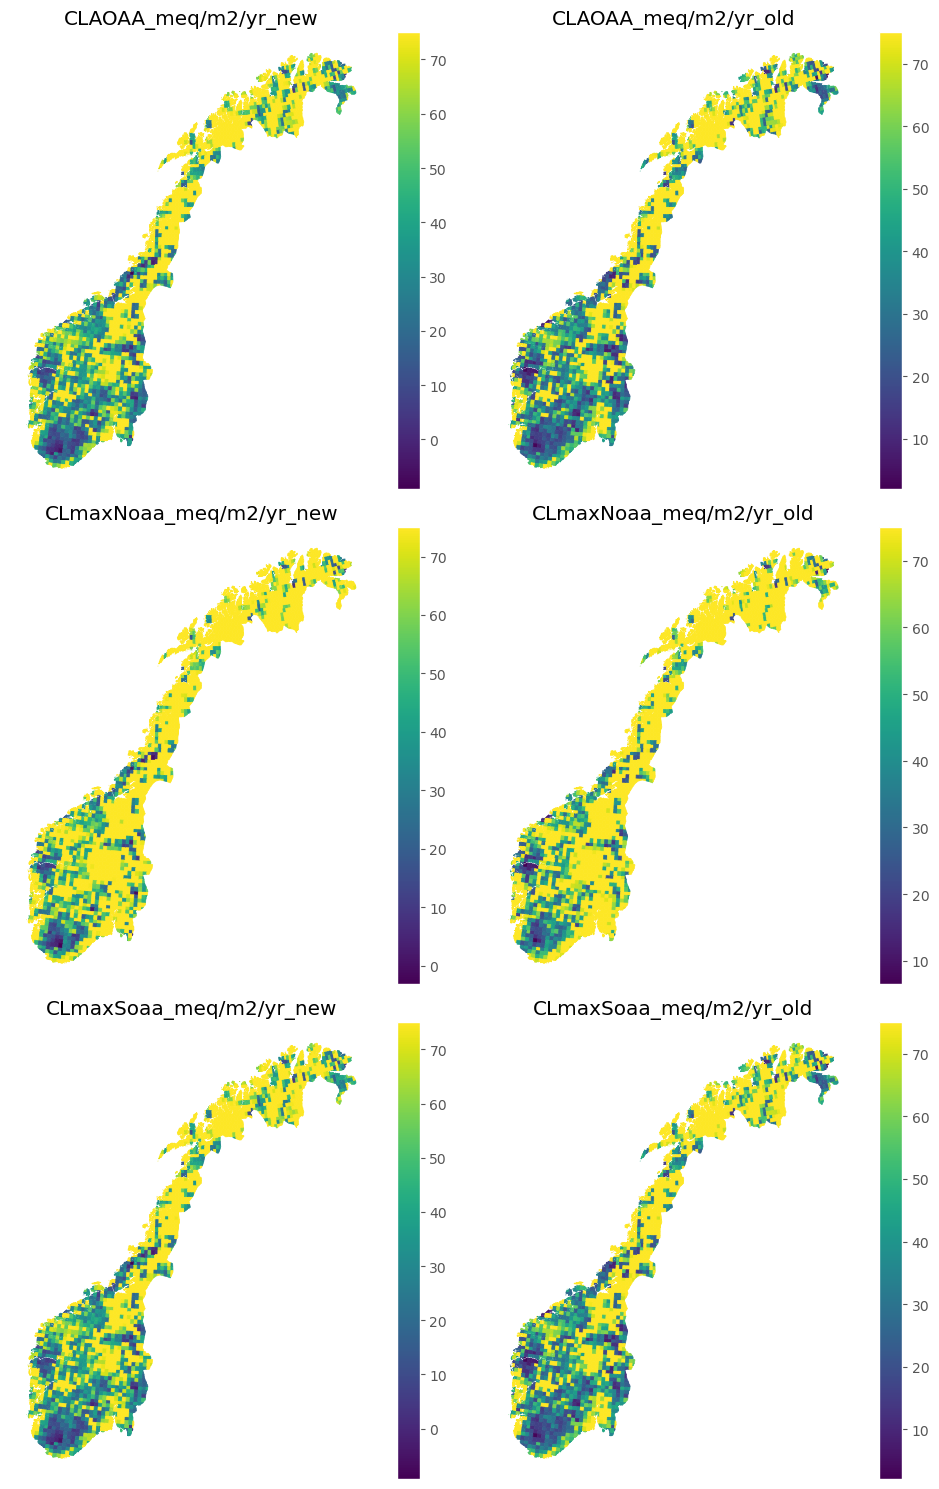

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))
axes = axes.flatten()
for idx, par in enumerate(par_list):
    comp_gdf.plot(column=par, ax=axes[idx], legend=True, vmax=75, edgecolor="face")
    axes[idx].set_title(par)
for ax in axes:
    ax.axis("off")
plt.tight_layout()